In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.model_selection import (train_test_split, 
                                    KFold, 
                                    cross_validate,
                                    GridSearchCV)
from ISLP import load_data

# Exercise 7

In [10]:
Boston = load_data('Boston')
Boston

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,6.48,22.0


In [38]:
X = Boston.drop('medv', axis=1)
y = Boston.medv

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [39]:
from tqdm import tqdm
def random_forest(n_estimators, max_features):
    rf = RF(n_estimators=n_estimators, max_features=max_features, random_state=0)
    rf.fit(X_train, y_train)
    results = rf.predict(X_test)
    errors = (y_test - results) ** 2
    return errors.mean()

def optimize(method, n_estimators_max, n_features):
    errors = {}
    for p in tqdm(n_features):
        errors[p] = []
        for i in range(1,n_estimators_max, 10):
            error = random_forest(n_estimators=i, max_features=p)
            errors[p].append(error)


    return errors

p = X_train.shape[1]
n_estimators_max = 200
n_features = [p, int(p/2), int(np.sqrt(p)), 1]
errors = optimize(random_forest, n_estimators_max, n_features)


    
        
         


    

    
    

100%|█████████████████████████████████████████████| 4/4 [00:06<00:00,  1.67s/it]


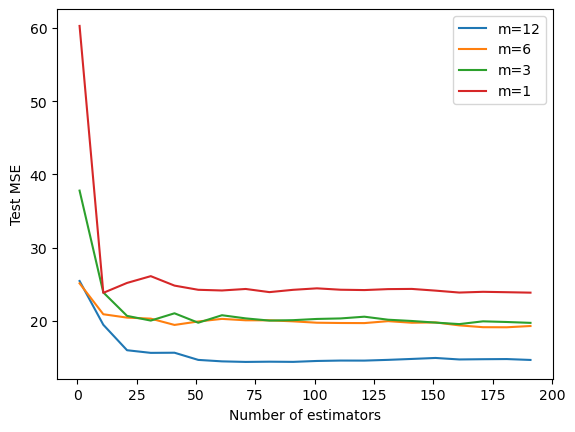

In [40]:
for p in n_features:
    plt.plot(range(1,n_estimators_max, 10), errors[p], label=f'm={p}')

plt.xlabel('Number of estimators')
plt.ylabel('Test MSE')
plt.legend()
plt.show()

# Exercise 8

In [41]:
Carseats = load_data('Carseats')
Carseats

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No
...,...,...,...,...,...,...,...,...,...,...,...
395,12.57,138,108,17,203,128,Good,33,14,Yes,Yes
396,6.14,139,23,3,37,120,Medium,55,11,No,Yes
397,7.41,162,26,12,368,159,Medium,40,18,Yes,Yes
398,5.94,100,79,7,284,95,Bad,50,12,Yes,Yes


In [82]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import (DecisionTreeRegressor as DTR,
                          plot_tree)
from sklearn.metrics import mean_squared_error

categorical_cols = [col for col in Carseats.columns if Carseats[col].dtype in ['object', 'category']]

encoder = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(), categorical_cols)
    ],
    remainder='passthrough'
)

X = Carseats.drop('Sales', axis=1)
X_encoded = encoder.fit_transform(X)
y = Carseats.Sales


# Recreate column names
onehot_columns = encoder.named_transformers_['onehot'].get_feature_names_out(categorical_cols)
non_categorical_cols = [col for col in X.columns if col not in categorical_cols]
new_column_names = list(onehot_columns) + non_categorical_cols

# Convert to DataFrame
X_encoded_df = pd.DataFrame(X_encoded, columns=new_column_names)
X = X_encoded_df



X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=0)

Test MSE = 5.195482499999999


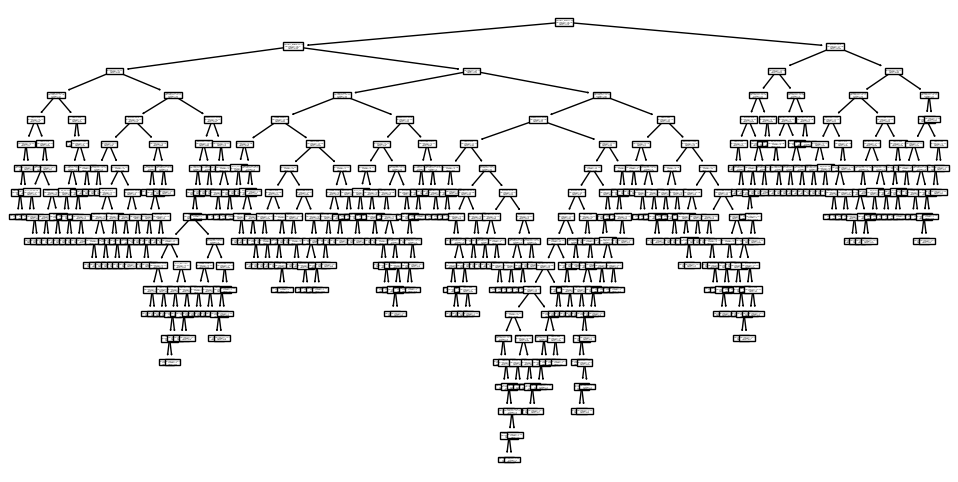

In [86]:
reg = DTR(random_state=0)
reg.fit(X_train, y_train)
ax = plt.subplots(figsize=(12,6))[1]
plot_tree(reg,
          feature_names=new_column_names,
          ax = ax);
y_pred = reg.predict(X_test)
error = mean_squared_error(y_pred, y_test)
print(f'Test MSE = {error}')

In [138]:
# c)
ccp_path = reg.cost_complexity_pruning_path(X_train, y_train)
kfold = KFold(n_splits=10,
              shuffle=True,
              random_state=0
             )
results = GridSearchCV(reg,
                       {'ccp_alpha': ccp_path.ccp_alphas},
                       refit=True,
                       cv=kfold,
                      scoring='neg_mean_squared_error')
results.fit(X_train, y_train);         

Test MSE = 3.9191531968381152


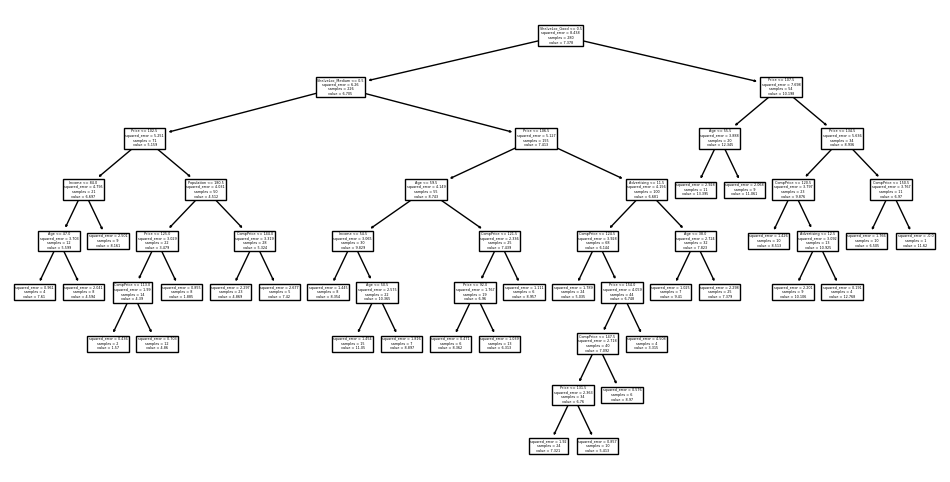

In [139]:
best_ = results.best_estimator_
y_pred = best_.predict(X_test)
MSE = np.mean((y_pred - y_test) ** 2)
print(f'Test MSE = {MSE}')
ax = plt.subplots(figsize=(12,6))[1]
plot_tree(best_,
          feature_names=new_column_names,
            ax=ax);

In [133]:
# d)
rf = RF(max_features=X.shape[1], random_state=0)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
MSE = np.mean((y_pred - y_test) ** 2)
print(f'Test MSE = {MSE}\n')

importances = rf.feature_importances_
for feature, importance in zip(new_column_names, importances):
    print(f'{feature}: {importance:.4f}')

index = np.where(importances == max(importances))[0][0]
print(f'\nMost important feature = {new_column_names[index]}')

Test MSE = 2.121071713583334

ShelveLoc_Bad: 0.0857
ShelveLoc_Good: 0.1763
ShelveLoc_Medium: 0.0477
Urban_No: 0.0029
Urban_Yes: 0.0028
US_No: 0.0033
US_Yes: 0.0035
CompPrice: 0.0982
Income: 0.0518
Advertising: 0.0723
Population: 0.0423
Price: 0.2769
Age: 0.1049
Education: 0.0314

Most important feature = Price


In [142]:
#e)
def random_forest(max_features, n_estimators, random_state=0):
    rf = RF(max_features=max_features, n_estimators=n_estimators, random_state=random_state)
    rf.fit(X_train, y_train)
    return rf

p = X.shape[1]
m_values = [p, int(p/2), int(np.sqrt(p))]
MSE = {m: [] for m in m_values}
for m in m_values:
    for n_est in range(1, 300, 20):
        rf = random_forest(max_features=m, n_estimators=n_est)
        y_pred = rf.predict(X_test)
        current_MSE = np.mean((y_pred - y_test) ** 2)
        MSE[m].append(current_MSE)

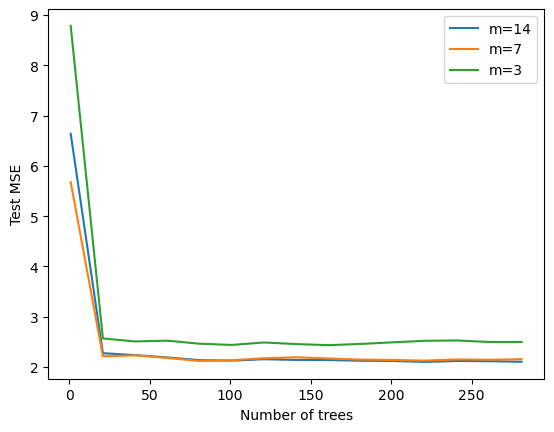

In [143]:
for m in m_values:
    plt.plot(range(1, 300, 20), MSE[m], label=f'm={m}')
plt.xlabel('Number of trees')
plt.ylabel('Test MSE')
plt.legend()
plt.show()

In [149]:
best
feature_importance = pd.DataFrame({'importance': rf.feature_importances_},
                                  index=new_column_names)
feature_importance_sorted = feature_importance.sort_values(by='importance', ascending=False)
feature_importance_sorted

,importance
Price,0.208949
ShelveLoc_Good,0.127484
Age,0.110796
ShelveLoc_Bad,0.091941
CompPrice,0.087916
Income,0.085238
Advertising,0.078841
Population,0.075753
Education,0.050686
ShelveLoc_Medium,0.035006
